<a href="https://colab.research.google.com/github/NicoleThumma/6.832-final-project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orbital Transfer via Trajectory Optimization

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [13]:
#@title
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='845157815a58bb51e2033b9c27f235df688e23f6', drake_version='0.25.0', drake_build='releases')

# Setup matplotlib backend (to notebook, if possible, or inline).  
from underactuated.jupyter import setup_matplotlib_backend
plt_is_interactive = setup_matplotlib_backend()

In [14]:
#@title
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# pydrake imports
from pydrake.all import (Variable, SymbolicVectorSystem, DiagramBuilder,
                         LogOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, SnoptSolver, PiecewisePolynomial)

from pydrake.all import (AddMultibodyPlantSceneGraph,
                         LinearQuadraticRegulator, Parser,
                         PlanarSceneGraphVisualizer, Linearize)

# increase default size matplotlib figures
from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 5)

# underactuated imports
from underactuated import FindResource


In [15]:
#PARAMETERS
random_seed = 5 #sets the seed for randomness is creating the obstacles
years = 5 #time interval, operates best between .5 and 1.5
proximity_weighting = 10 #weighting factor for the waypoints

#ROCKET SPECIFIC
max_vel = 150
min_vel = 50

## Problem Description

Simplifying assumptions:
- the environment is 2D,
- the objects are circles that do not move

Goals:
- enforce state and input limits
- enforce minimum speed
- (minimize the fuel consumption)
- avoid obstacles

Below are the units of measurements in this problem: this is a fundamental step to prevent the solver from having numeric issues.

In [16]:
# dictionary of functions to convert the units of the problem data
# the fist argument is the numeric value we want to convert
# the second argument is the unit power
# e.g., m = 2 and power = 2 for square meters
unit_converter = {
    'mass':   lambda m, power=1 : m / 1e3 ** power, # takes kilos, returns tons
    'length': lambda l, power=1 : l / 1e11 ** power, # takes meters, returns hundreds of gigameters
    'time':   lambda t, power=1 : t / (60 * 60 * 24 * 30 * 12)  ** power, # takes seconds, returns years
}


## Model of the 2D Universe

Aircraft model is [SpaceX Falcon 9 rocket](https://www.spacex.com/vehicles/falcon-9).

Ridiculously tight limits on the maximum thrust and velocity.

(The true reason for these tiny limits is a mixture of modeling and numeric issues. If you feel like, give the true [Falcon 9 specs](https://www.spacex.com/vehicles/falcon-9) a try!)

In [17]:
# simple class to store the rocket data
class Rocket(object):
    
    def __init__(
        self,
        mass,           # mass of the rocket in kg
        thrust_limit,   # max norm of the thrust in kg * m * s^-2
        velocity_limit,  # max norm of the velocity in m * s^-1
        velocity_lower_limit # min norm of the velocity in m * s^-1
    ):
        
        # store mass using the scaled units
        self.mass = unit_converter['mass'](mass)
        
        # store thrust limit converting the units one by one
        thrust_units = [('mass', 1), ('length', 1), ('time', -2)]
        for (quantity, power) in thrust_units:
            print("pre:", thrust_limit)
            thrust_limit = unit_converter[quantity](thrust_limit, power)
            print("post:", thrust_limit)
        self.thrust_limit = thrust_limit
        
        # store velocity limit converting the units one by one
        velocity_units = [('length', 1), ('time', -1)]
        for (quantity, power) in velocity_units:
            velocity_limit = unit_converter[quantity](velocity_limit, power)
            velocity_lower_limit = unit_converter[quantity](velocity_lower_limit, power)
        self.velocity_limit = velocity_limit
        self.velocity_lower_limit = velocity_lower_limit
        
# instantiate the rocket
rocket = Rocket(
    5.49e5, # mass of Falcon 9 in kg
    .25, # * (60 * 60 * 24 * 30 * 12),    # very small thrust limit in kg * m * s^-2
    max_vel, # * (60 * 60 * 24 * 30 * 12),    # very small velocity limit in m * s^-1
    min_vel # * (60 * 60 * 24 * 30 * 12)      # test min
)

print(rocket.thrust_limit)
print(rocket.velocity_limit)
print(rocket.velocity_lower_limit)
print((2.5e-15)/(60 * 60 * 24 * 30 * 12)**(-2))
#2.41864704
#0.0046656
#0.0015551999999999999

pre: 0.25
post: 0.00025
pre: 0.00025
post: 2.5e-15
pre: 2.5e-15
post: 2.41864704
2.41864704
0.046655999999999996
0.015552
2.41864704


Region class.
The start and end will be instances of this class, as well as the obstacles.

This class has a parameter called `orbit`.
For the start, this is the radius of the region from which our mission starts.

For end, this is the radius of the target region.
For the obstacles, this is the radius of a "danger area" centered at the obstacle itself that we want our aircraft to avoid.

In [18]:
# each location/obstacle in the problem must be an instance of this class
class Region(object):
    
    def __init__(
        self,
        name,          # string with the name of the region
        color,         # color of the region for plots
        position,      # position of the region in the 2d universe in m
        orbit,         # radius of the orbit in m
        radius=np.nan, # radius of the region in m (optional)
    ):
        
        # store the data using the scaled units
        self.name = name
        self.position = unit_converter['length'](position)
        self.radius = unit_converter['length'](radius)
        self.orbit = unit_converter['length'](orbit)
        self.color = color
        
start = Region(
    'Start',                # name of the region
    'green',                # color for plot
    np.array([2.25e11, 0]), # (average) distance wrt End in m
    2e9,                   # orbit radius in m (chosen "big enough" for the plots)
)

end = Region(
    'End',      # name of the region
    'red',       # color for plot
    np.zeros(2), # End is chosen as the origin of our 2D universe
    2e9,      # orbit radius in m
)

waypoints = []
# waypoint_name = []
points = [[1e11+5e10, 5e10], [1e11-5e10, 5e10]]
for i in range(len(points)):
  new_waypoint = Region(
    'Waypoint_'+str(i+2),      # name of the region
    'blue',       # color for plot
    np.array(points[i]), # End is chosen as the origin of our 2D universe
    2e9,      # orbit radius in m
  )
  # waypoint_names.append('Waypoint_'+str(i))
  waypoints.append(new_waypoint)

# obstacles with random data in random positions
np.random.seed(random_seed)
n_obstacles = 10
obstacles = []
for i in range(n_obstacles):
    orbit = (np.abs(np.random.randn())+1)/2 * 1e10
    start_from_end = unit_converter['length'](start.position, -1)
    obstacle_from_end = np.random.randn(2) * 3e10 + start_from_end / 2 #2d 
    
    obstacles.append(
        Region(
            f'Obstacle_{i}',    # name
            'brown',            # color for plot
            obstacle_from_end, # distance from End in m
            orbit        # radius danger area in m
        )
    )
print(waypoints[0].name)

Waypoint_2


Let's put all the pieces together in ours 2D universe.
The class `Universe` also implements some utility functions that will be helpful when setting up the optimization problem.
For example, for the piece of code you'll be asked to write, you might consider using the `position_wrt_region` method.

In [19]:
# main class of the notebook
# it collects the rocket, the regions, and all the obstacles
# implements utility functions needed to write the trajopt
class Universe(object):
    
    def __init__(
        self,
        rocket, # instance of Rocket
        regions # list of instances of Regions
    ):
        
        # store data
        self.rocket = rocket
        self.regions = regions

            
    # given the region name, returns the Region instance
    def get_region(self, name):
        
        # loop through the regions in the universe
        for region in self.regions:
            if region.name == name:
                return region
            
        # in case no region has the given name
        print(name + ' is not in the Universe!')
        
    # computes  2D distance vector between the rocket and a region,
    # given the rocket state and the region name
    def position_wrt_region(self, state, name):
        
        # rocket position wrt to the region position
        region = self.get_region(name)
        p = state[:2] - region.position

        return p
    
    # right-hand side of the rocket continuous-time dynamics
    # in the form state_dot = f(state, thrust)
    # (thrust is a 2D vector with the horizontal and vertical thrusts)
    def rocket_continuous_dynamics(self, state, thrust):

        # thrust acceleration
        a = thrust / self.rocket.mass
            
        # concatenate velocity and acceleration
        state_dot = np.concatenate((state[2:], a))
            
        return state_dot

    def rocket_get_next_step(self, state, thrust, time_step):
      state_dot = self.rocket_continuous_dynamics(state, thrust)
      return state + time_step * state_dot

    
    # residuals of the rocket discrete-time dynamics
    # if the vector of residuals is zero, then this method's
    # arguments verify the discrete-time dynamics
    # (implements the implicit Euler integration scheme:
    # https://en.wikipedia.org/wiki/Backward_Euler_method)
    def rocket_discrete_dynamics(self, state, state_next, thrust, time_step):
        
        # continuous-time dynamics evaluated at the next time step
        state_dot = self.rocket_continuous_dynamics(state_next, thrust)
        
        # implicit-Euler state update
        residuals = state_next - state - time_step * state_dot
        
        return residuals

            
            
# instantiate universe
regions = [start, end] + obstacles + waypoints
universe = Universe(rocket, regions)
print(universe.get_region("Start"))

## Plot Functions

Here are some plot functions that will help us visualizing the results.
You'll find these useful when improving the trajectory as explained below.
As always, no need to fully understand what's going on here, unless you're a `matplotlib` enthusiast...

In [20]:
#@title
# helper function that plots a circle centered at
# the given point and with the given radius
def plot_circle(center, radius, *args, **kwargs):
    
    # discretize angle
    angle = np.linspace(0, 2*np.pi)
    
    # plot circle
    plt.plot(
        center[0] + radius * np.cos(angle),
        center[1] + radius * np.sin(angle),
        *args,
        **kwargs
    )

# function that draws the state-space trajectory of the rocket
# including the regions and the obstacles
def plot_state_trajectory(trajectory, universe):
    
    for region in universe.regions:
        
        # plot regions
        plt.scatter(*region.position, s=100, c=region.color)
        plt.text(*region.position, region.name)
    
        # plot orbits
        if not np.isnan(region.orbit):
            if region.name == 'Obstacle_1':
                orbit_label = 'Obstacle danger area'
            elif region.name[:8] == 'Obstacle':
                orbit_label = None
            else:
                orbit_label = region.name + ' orbit'
            plot_circle(
                region.position,
                region.orbit,
                label=orbit_label,
                color=region.color,
                linestyle='--'
            )
    
    # plot rocket trajectory
    plt.plot(trajectory.T[0], trajectory.T[1], color='k', label='Rocket trajectory')
    plt.scatter(trajectory[0,0], trajectory[0,1], color='k')
    
    # misc settings
    length_unit = unit_converter['length'](1)
    plt.xlabel('{:.0e} meters'.format(length_unit))
    plt.ylabel('{:.0e} meters'.format(length_unit))
    plt.grid(True)
    plt.gca().set_aspect('equal')
    
    # legend
    n_legend = len(plt.gca().get_legend_handles_labels()[0])
    plt.legend(
        loc='upper center',
        ncol=int(n_legend / 2),
        bbox_to_anchor=(.5, 1.25),
        fancybox=True,
        shadow=True
    )

# function that plots the norm of the rocket thrust and
# velocity normalized on their maximum value
def plot_rocket_limits(rocket, thrust, state):
    
    # reconstruct time vector
    time_steps = thrust.shape[0]
    time = np.linspace(0, time_steps, time_steps + 1)
    
    # plot maximum norm limit
    plt.plot(time, np.ones(time_steps + 1), 'r--', label='Upper Limit')

    # plot minimum norm limit

    plt.plot(time, np.full(time_steps + 1, 1/3), 'r--', label='Lower Limit')
    
    # plot normalized thrust
    thrust_norm = [np.linalg.norm(t) / rocket.thrust_limit for t in thrust]
    plt.step(time, [thrust_norm[0]] + thrust_norm, label='Thrust / thrust limit')
    
    # plot normalized velocity
    velocity_norm = [np.linalg.norm(v) / rocket.velocity_limit for v in state[:,2:]]
    plt.plot(time, velocity_norm, label='Velocity / velocity limit')
    
    # plot limits
    plt.xlim(0, time_steps)
    ymax = max(1, max(thrust_norm), max(velocity_norm)) * 1.05
    plt.ylim(0, ymax)
    
    # misc settings
    plt.xlabel('Time step')
    plt.grid(True)
    plt.legend()

## Trajectory Optimization


In [21]:
# function that interpolates two given positions of the rocket
# velocity is set to zero for all the times
def interpolate_rocket_state(p_all, time_steps):
    np.random.seed(1)

    num_waypoints = len(p_all)-1
    
    # initial and final time and state
    time_limits = [0., time_steps * time_interval/num_waypoints]

    min_vels = []
    for i in range(num_waypoints):
      p_diff = p_all[i+1] - p_all[i]
      norm_p_diff = p_diff/np.sqrt(p_diff[0]**2 + p_diff[1]**2)
      min_vels.append(min_vel*norm_p_diff)
    min_vels.append(min_vels[-1])
    min_vels = np.array(min_vels)

    state_guess = np.array([[0, 0, 0, 0]])
    for i in range(num_waypoints):
        position_limits = np.column_stack((p_all[i], p_all[i+1]))
        
        state_limits = np.vstack((position_limits, np.column_stack((min_vels[i], min_vels[i+1])))) #Change to be in direction of next point at min vel

        # linear interpolation in state
        state = PiecewisePolynomial.FirstOrderHold(time_limits, state_limits)
        # sample state on the time grid and add small random noise
        if i == num_waypoints-1: 
            remaining_steps = (time_steps+2) - state_guess.shape[0] #safety measure
            state_guess = np.concatenate((state_guess, np.vstack([state.value(t * time_interval).T for t in range(remaining_steps)]) ), axis=0)
        else:
            state_guess = np.concatenate((state_guess, np.vstack([state.value(t * time_interval).T for t in range(int(time_steps/num_waypoints))]) ), axis=0 )

    state_guess = state_guess[1:]
    state_guess += np.random.rand(*state_guess.shape) * 5e-6
    
    return state_guess

In [22]:
# numeric parameters
time_interval = years # in years
time_steps = 100

# initialize optimization
prog = MathematicalProgram()

# optimization variables
state = prog.NewContinuousVariables(time_steps + 1, 4, 'state')
thrust = prog.NewContinuousVariables(time_steps, 2, 'thrust')

# initial orbit constraints
prog.AddConstraint(universe.position_wrt_region(state[0], 'Start').dot(universe.position_wrt_region(state[0], 'Start')) <= start.orbit**2)
prog.AddConstraint(state[0][2:4].dot(state[0][2:4]) == rocket.velocity_lower_limit**2)

# terminal orbit constraints
# prog.AddConstraint(universe.position_wrt_region(state[-1], 'End').dot(universe.position_wrt_region(state[-1], 'End')) <= end.orbit**2)

# discretized dynamics
for t in range(time_steps):
    residuals = universe.rocket_discrete_dynamics(state[t], state[t+1], thrust[t], time_interval)
    for residual in residuals:
        prog.AddConstraint(residual == 0)
    
# initial guess
waypoint_positions = [universe.get_region('Start').position] + [way.position for way in waypoints] + [universe.get_region('End').position]
# waypoint_positions = [universe.get_region('Start').position] + [universe.get_region('End').position]

state_guess = interpolate_rocket_state(
    waypoint_positions,
    time_steps
)
prog.SetInitialGuess(state, state_guess)

In [23]:
# velocity limits, for all t:
# two norm of the rocket velocity
# lower or equal to the rocket velocity_limit

for t in range(time_steps):
  prog.AddConstraint(state[t][2:4].dot(state[t][2:4]) <= rocket.velocity_limit**2)
for t in range(time_steps):
  prog.AddConstraint(state[t][2:4].dot(state[t][2:4]) >= rocket.velocity_lower_limit**2)

# avoid collision with obstacles, for all t, for all obstacles:
# two norm of the rocket distance from the obstacle
# greater or equal to the obstacle orbit

for t in range(time_steps):
  for obstacle in obstacles:
    prog.AddConstraint(universe.position_wrt_region(state[t], obstacle.name).dot(universe.position_wrt_region(state[t], obstacle.name)) >= obstacle.orbit**2)

# minimize fuel consumption, for all t:
# add to the objective the two norm squared of the thrust
# multiplied by the time_interval so that the optimal cost
# approximates the time integral of the thrust squared

#Automate waypoint cost addition

prog.AddCost(
            time_interval * (sum(t.dot(t) for t in thrust)) 
            +proximity_weighting*time_steps*universe.position_wrt_region(state[-1], 'End').dot(universe.position_wrt_region(state[-1], 'End'))
            +proximity_weighting*time_steps*universe.position_wrt_region(state[int(time_steps/3)], 'Waypoint_2').dot(universe.position_wrt_region(state[int(time_steps/3)], 'Waypoint_2'))
            +proximity_weighting*time_steps*universe.position_wrt_region(state[int(2*time_steps/3)], 'Waypoint_3').dot(universe.position_wrt_region(state[int(2*time_steps/3)], 'Waypoint_3'))
           )
# prog.AddCost(universe.position_wrt_region(state[-1], 'End').dot(universe.position_wrt_region(state[-1], 'End')))


# thrust limits, for all t:
# two norm of the rocket thrust
# lower or equal to the rocket thrust_limit

for t in range(time_steps):
  prog.AddConstraint(thrust[t].dot(thrust[t]) <= rocket.thrust_limit**2)

Now that we have written the optimization problem, we can solve it using the nonlinear optimization solver `Snopt`.


In [24]:
# solve mathematical program
solver = SnoptSolver()
result = solver.Solve(prog)

# be sure that the solution is optimal
assert result.is_success()

# retrieve optimal solution
thrust_opt = result.GetSolution(thrust)
state_opt = result.GetSolution(state)

## Plot the Optimization Results

Here is a visualization of the optimal state trajectory.
Note that we would like the trajectory of the rocket not to intersect any of the danger areas around the obstacles.

[2.25 0.  ]
[ 2.26170582 -0.01621647]
[0. 0.]
[-0.00183814  0.00089965]


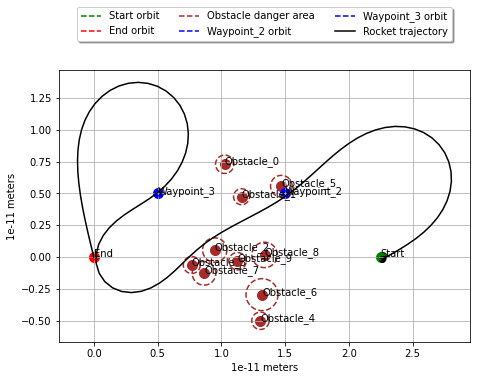

In [25]:
plt.figure()
plot_state_trajectory(state_opt, universe)
print(start.position)
print(state_opt[0][0:2])
print(end.position)
print(state_opt[-1][0:2])

Here are the ratios between the 2 norm of the rocket thrust and velocity and their maximum values.
Note that we would like these ratios not to exceed one (labeled as "Limit" in the plot).

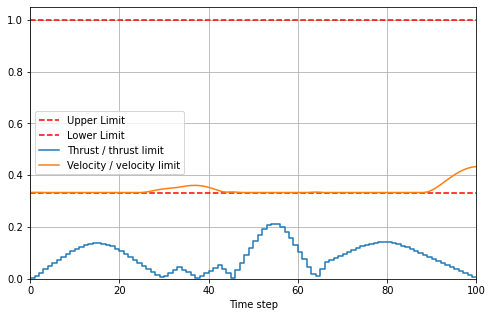

In [26]:
plt.figure()
plot_rocket_limits(rocket, thrust_opt, state_opt)

In [27]:

def plot_distance_to_waypoints(state):
    time_steps = state.shape[0]
    time = np.linspace(0, time_steps, time_steps)
    all_regions = [start] + waypoints + [end]
    max_dist = 0.0

    # reconstruct time vector
    all_distances = [[] for i in range(len(all_regions))]
    for i in range(len(all_regions)):
      for s in state_opt:
        current_pos = universe.position_wrt_region(s, all_regions[i].name)
        current_dist = np.sqrt(current_pos[0]**2 + current_pos[1]**2)
        max_dist = max(max_dist, current_dist)
        all_distances[i].append(current_dist)

      plt.step(time, all_distances[i], label=all_regions[i].name+' Distance')
    
    # plot limits
    plt.xlim(0, time_steps)
    ymax = max_dist * 1.05
    plt.ylim(0, ymax)
    
    # misc settings
    plt.xlabel('Time step')
    plt.grid(True)
    plt.legend()

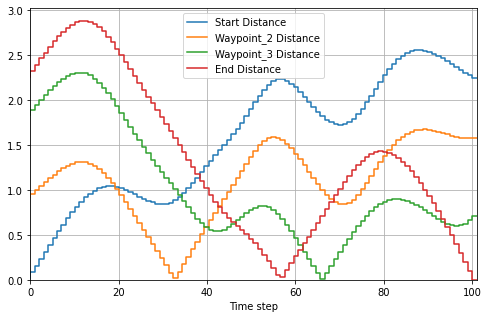

In [28]:
plt.figure()
plot_distance_to_waypoints(state_opt)



If you're struggling trying to find the right functions to complete your task, here are two great resources:
- [Drake's MathematicalProgram documentation](https://drake.mit.edu/doxygen_cxx/classdrake_1_1solvers_1_1_mathematical_program.html).
This is the `C++` documentation, but it's very useful to see which methods `MathematicalProgram` implements and what you need to pass to them.
- [Drake's nonlinear-programming tutorial](https://mybinder.org/v2/gh/RobotLocomotion/drake/nightly-release?filepath=tutorials).
Here you'll find usage examples of all the `MathematicalProgram` methods you need to complete this exercise.

**Troubleshooting:**
Nonlinear optimization solvers are extremely sensitive.
Different OSs can give different results.
Even worse, sometimes, enforcing the same constraints in a different order, you can make these solvers find a solution to a problem that they previously said was infeasible!
In our Colab testings, we implemented the constraints in the order given above, and we got full score.
However, in case you believe that your implementation is correct but you still don't get full score from the autograder, feel free to play with the initial-guess parameters (e.g. the random seed).

CONVERTING TO REASONABLE UNITS

In [29]:
#thrust opt, state opt

In [30]:
print(state_opt[0]) #x pos, y pos, x vel, y vel
x_pos = []
y_pos = []
x_vel = []
y_vel = []
for i in range(len(state_opt)):
  x_pos.append(round(state_opt[i][0], 4))
  y_pos.append(round(state_opt[i][1], 4))
  x_vel.append(round(state_opt[i][2], 4))
  y_vel.append(round(state_opt[i][3], 4))
for i in [x_pos, y_pos, x_vel, y_vel]:
  to_print = []
  for j in i:
    to_print.append(j*1e3)
  # print(to_print)

# print(thrust_opt[0][0]*1e3) #x thrust, y thrust
# print(thrust_opt[0][0])

unit_changed_state_opt = []
unit_changed_thrust_opt = []
for state in state_opt:
  unit_changed_state_opt.append(state*1000)
for thrust in thrust_opt:
  unit_changed_thrust_opt.append(thrust*1000)

#ignore since rocket dynamics are still used

[ 2.26170582 -0.01621647  0.0135914   0.00755901]


ADDING WIND EFFECTS

In [31]:
mass = rocket.mass
#Scrapped time since wind presents a challenge anyway and there's no 
#straightforward way to incorporate time with the simulation
def wind_acc():
  max_acc = (3,3)
  f_x, f_y = max_acc #*np.random.rand() #if implementation works, will add randomness
  return f_x, f_y

IMPORTS FROM CARTPOLE BALANCING

In [32]:
# fill these states with the ones given above
# x_list = [
#     np.array([0, .99*np.pi, 0, 0]),
#     np.array([0, .9*np.pi, 0, 0]),
#     np.array([0, .85*np.pi, 0, 0]),
#     np.array([0, .5*np.pi, 0, 0]),
#     np.array([0, 0, 0, 0]),
#     np.array([1, np.pi, 0, 0])
# ]
# x_list = [unit_changed_state_opt[0]]
x_list = [state_opt[-1]]
print(x_list)


[array([-0.00183814,  0.00089965,  0.00479739, -0.0196617 ])]


In [33]:
# unstable equilibrium point
x_star = [0, np.pi, 0, 0]
x_star = state_opt[-1]

# weight matrices for the lqr controller
Q = np.eye(4)
R = np.eye(1)

In [34]:
#URDF for rocket
base_urdf = """
  <link name="base">
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 0" />
      <geometry>
        <box size=".5 .2 .2" />
      </geometry>
      <material>
        <color rgba="0 1 0 1" />
      </material>
    </visual>

    <visual>
      <origin xyz=".15 0 -.15" rpy="0 0 0" />
      <geometry>
        <sphere radius=".05" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
    
    <visual>
      <origin xyz="-.15 0 -.15" rpy="0 0 0" />
      <geometry>
        <sphere radius=".05" />
      </geometry>
      <material>
        <color rgba="0 0 0 1" />
      </material>
    </visual>
  </link>
"""

In [35]:
# # start construction site of our block diagram
# builder = DiagramBuilder()

# # instantiate the cart-pole and the scene graph
# cartpole, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
# urdf_path = FindResource('models/undamped_cartpole.urdf')
# Parser(cartpole).AddModelFromFile(urdf_path)
# cartpole.Finalize()

# # set the operating point (vertical unstable equilibrium)
# context = cartpole.CreateDefaultContext()
# context.get_mutable_continuous_state_vector().SetFromVector(x_star)

# # fix the input port to zero and get its index for the lqr function
# cartpole.get_actuation_input_port().FixValue(context, [0])
# input_i = cartpole.get_actuation_input_port().get_index()

# # synthesize lqr controller directly from
# # the nonlinear system and the operating point
# lqr = LinearQuadraticRegulator(cartpole, context, Q, R, input_port_index=input_i)
# lqr = builder.AddSystem(lqr)

# # the following two lines are not needed here...
# output_i = cartpole.get_state_output_port().get_index()
# cartpole_lin = Linearize(cartpole, context, input_port_index=input_i, output_port_index=output_i)

# # wire cart-pole and lqr
# builder.Connect(cartpole.get_state_output_port(), lqr.get_input_port(0))
# builder.Connect(lqr.get_output_port(0), cartpole.get_actuation_input_port())

# # add a visualizer and wire it
# visualizer = builder.AddSystem(
#     PlanarSceneGraphVisualizer(scene_graph, xlim=[-3., 3.], ylim=[-1.2, 1.2], show=False)
# )
# builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))

# # finish building the block diagram
# diagram = builder.Build()

# # instantiate a simulator
# simulator = Simulator(diagram)
# simulator.set_publish_every_time_step(False) # makes sim faster

In [36]:
# # function that given the cart-pole initial state
# # and the simulation time, simulates the system
# # and produces a video
# def simulate_and_animate(x0, sim_time=5):
    
#     # start recording the video for the animation of the simulation
#     visualizer.start_recording()
    
#     # reset initial time and state
#     context = simulator.get_mutable_context()
#     context.SetTime(0.)
#     context.SetContinuousState(x0)
    
#     # run sim
#     simulator.Initialize()
#     simulator.AdvanceTo(sim_time)
    
#     # stop video
#     visualizer.stop_recording()
    
#     # construct animation
#     ani = visualizer.get_recording_as_animation()
    
#     # display animation below the cell
#     display(HTML(ani.to_jshtml()))
    
#     # reset to empty video
#     visualizer.reset_recording()

In [37]:
# # simulate and animate the cart
# for x in x_list:
#     simulate_and_animate(x)

In [38]:
# system_recovers_from_states = [i for i in range(len(x_list))] # modify here
# print('System recovers from states:')
# for i in system_recovers_from_states:
#     print(np.around(x_list[i], decimals=2))